In [1]:
import os
from PIL import Image
from tqdm import tqdm
import numpy as np
import pandas as pd
from os import walk
import cv2
import json
import skimage.io
import skimage.color
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
import math
import multiprocessing as mp

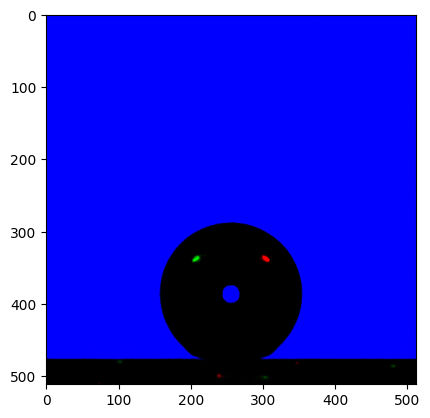

image shape [v,u,c]: (512, 512, 3)


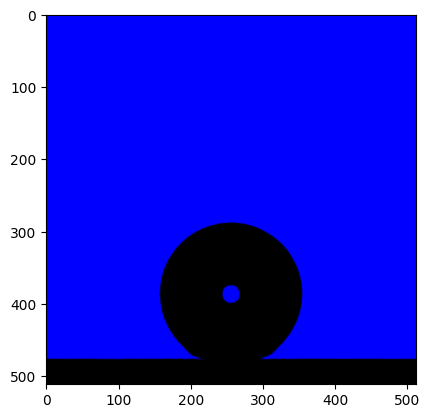

image shape [v,u,c]: (512, 512)


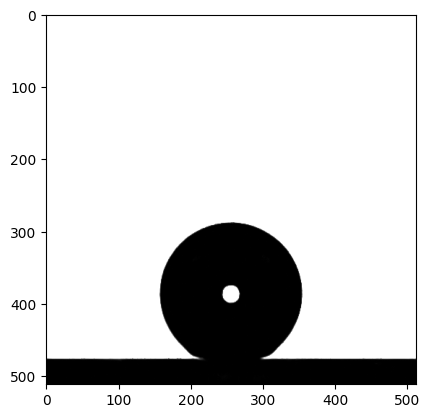

In [2]:
# Removing the glare-points from the image and transforming it to grey values
path = "/pfs/work7/workspace/scratch/oy0026-DDE2_droplet/RENDER/0010/0_0_00.png" #0304/220_0_00.png"
image = skimage.io.imread(path)
rgb_img = skimage.color.rgba2rgb(image)
plt.imshow(rgb_img, cmap = "gray")
plt.show()
print(f"image shape [v,u,c]: {rgb_img.shape}")
rgb_img[:, :, 0:2] = 0
plt.imshow(rgb_img)
plt.show()
img_crop = skimage.color.rgb2gray(rgb_img) #[-50:-30]) #[-45:-37,:,:])
print(f"image shape [v,u,c]: {img_crop.shape}")
plt.imshow(img_crop, cmap = "gray")
plt.show()

In [3]:
# Defining the sobel kernel:
sobel_kernel = 1 / 8 * np.array([
    [-1., 0., 1.],
    [-2., 0., 2.],
    [-1., 0., 1.]
], dtype=float)

In [4]:
from typing import Tuple

# Calculating the gradients of the picture in du and dv direction as well as the magnitude and the angle using the sobel kernel
def calculate_gradients(*, gray_img: np.ndarray, kernel_u: np.ndarray, kernel_v: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    d_u = convolve2d(gray_img, kernel_u, mode="valid", fillvalue=1)
    d_v = convolve2d(gray_img, kernel_v, mode="valid", fillvalue=1)
    d_mag = np.sqrt(d_u ** 2 + d_v ** 2)
    d_angle = np.arctan2(d_u, d_v)

    return d_u, d_v, d_mag, d_angle

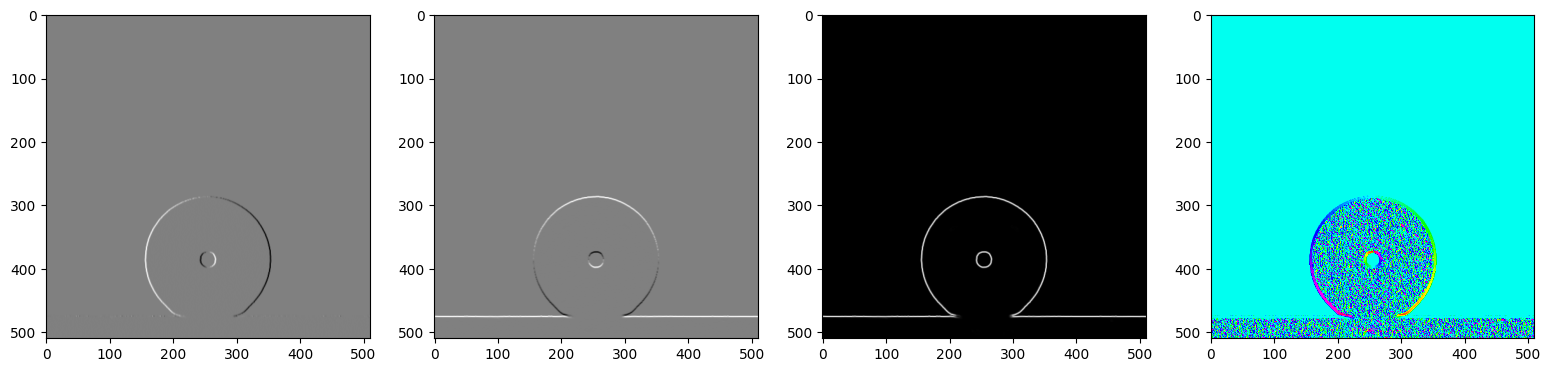

In [5]:
# Printing the reusults
d_u, d_v, d_mag, d_angle = calculate_gradients(gray_img=img_crop, kernel_u=sobel_kernel, kernel_v=sobel_kernel.transpose())
_, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
figure_size = plt.gcf().get_size_inches()
plt.gcf().set_size_inches(3 * figure_size)
ax1.imshow(d_u, cmap="gray")
ax2.imshow(d_v, cmap="gray")
ax3.imshow(d_mag, cmap="gray")
ax4.imshow(d_angle, cmap="hsv")
plt.show()

0.03768559689014049
(1121, 2)


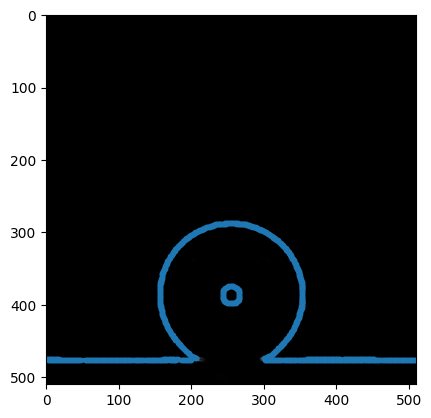

In [6]:
# Extracting all values where d_mag is over a certain, experimentally found threshold
print(d_mag.max())
d_mag_lines = np.argwhere(d_mag > 0.03)
print(d_mag_lines.shape)
_, ax = plt.subplots()
ax.imshow(d_mag, cmap="gray")
ax.scatter(d_mag_lines[:,1], d_mag_lines[:,0], marker = ".")
plt.show()

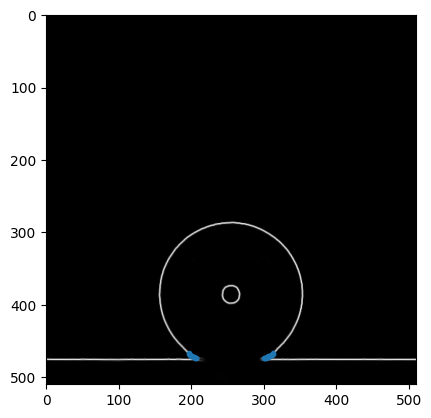

In [7]:
# Deleting all the points that are outside of our point of interest.
# The lower boundary is the ground of the picture and is similar to all pictures.abs# A height of 7 was found to provide good results
# All u values between 200 and 300 have to be removed since in this area, the glare point can be found.
idx = np.where((d_mag_lines[:, 0] > 512-38) | (d_mag_lines[:, 0] < 512-45) | (d_mag_lines[:, 1] > 210) & (d_mag_lines[:, 1] < 290))
droplet_lines = np.delete(d_mag_lines, idx, axis=0)

_, ax = plt.subplots()
ax.imshow(d_mag, cmap="gray")
ax.scatter(droplet_lines[:,1], droplet_lines[:,0], marker = ".")
plt.show()

In [8]:
# Now the angles can be extracted since we already calculated those using the gradients.
angles = np.abs(d_angle[droplet_lines[:,0], droplet_lines[:,1]]*180/math.pi)
print(angles)
np.average(angles)

[136.23818862 137.19287603 138.10992884 139.80635722 139.5391523
 151.52674504 145.58065582 147.77966328 149.78030267 147.60111659
 145.42371721 161.52389042 159.07549826 149.6525488  164.45277921
 167.22248017 161.52559128 158.48877487 159.91670667 160.85359888
 162.04383485 164.20236852 166.04549083 169.88604785 167.1077136
 157.79775738]


154.16822250825533

In [9]:
# Define a helper function that takes a subdirectory name and returns the angle and label
def process_subdirectory(path):
    obj_path = path[0]
    subdirectory = path[1]
    angles_one_droplet = []
    for i_image in os.listdir(obj_path + '/' + subdirectory):
        path = os.path.join(obj_path + '/' + subdirectory,i_image)
        # only use every 10° angle picture, not every one degree as there would be available for the droplet folder
        if i_image.endswith('0_0_00.png') and not (subdirectory+'/'+i_image) == ('0304/220_0_00.png'):
            # Reading the picture:    
            image = skimage.io.imread(path)
            # Extracting the relevant area in order to save computational resources.
            rgb_img_crop = skimage.color.rgba2rgb(image[-45:-38,:,:])
            rgb_img_crop[:, :, 0:2] = 0
            gray_img_crop = skimage.color.rgb2gray(rgb_img_crop)

            #Calculating the gradients
            d_u, d_v, d_mag, d_angle = calculate_gradients(gray_img=gray_img_crop, kernel_u=sobel_kernel, kernel_v=sobel_kernel.transpose())

            # filtering the relevant points
            d_mag_lines = np.argwhere(d_mag > 0.03)
            # Removing the area where glare points occur:
            idx = np.where((d_mag_lines[:, 1] > 210) & (d_mag_lines[:, 1] < 290))
            droplet_lines = np.delete(d_mag_lines, idx, axis=0)

            # Only do the calculations if values could be found
            if droplet_lines.size != 0:
                angles_one_picture = np.abs(d_angle[droplet_lines[:,0], droplet_lines[:,1]]*180/math.pi)
                angles_one_droplet.append(np.average(angles_one_picture))
    if len(angles_one_droplet) == 0:
        return np.nan, subdirectory
    else:
        return np.average(angles_one_droplet), subdirectory

# Creating a function to read the images from the files:
def angle_extractor(obj_path):      
    angles = []
    labels = []
    # Create a pool 
    pool = mp.Pool(mp.cpu_count())
    print(f"Using all {mp.cpu_count()} processor cores to parallelize task.")
    # Use imap to apply your function to each subdirectory and get an iterator of results
    subdirs = os.listdir(obj_path)
    results = tqdm(pool.imap(process_subdirectory, zip([obj_path] * len(subdirs), subdirs)), total = len(subdirs))
    # Iterate over the results and append them to the output lists
    for angle, label in results:
        angles.append(angle)
        labels.append(label)
    return angles, labels


In [10]:
# Reading the images
angles, labels = angle_extractor('/pfs/work7/workspace/scratch/oy0026-DDE2_droplet/RENDER')

Using all 80 processor cores to parallelize task.


100%|██████████| 1479/1479 [01:22<00:00, 17.92it/s]


In [11]:
# Sorting the data, as labels show that data is unsorted so far
angle_data = np.array(angles)
label_data = np.array(labels)
sortedIndices = np.argsort(label_data)
sorted_labels = label_data[sortedIndices]
sorted_angles = angle_data[sortedIndices]
print(sorted_labels)
print(sorted_angles.shape)

['0001' '0002' '0003' ... 'droplet0_97' 'droplet0_98' 'droplet0_99']
(1479,)


In [12]:
# For access over Visual Studio code, one has to move the directory to the git folder.
if os.getcwd().split("/")[-1] != "dde2_project":
    os.chdir("./dde2_project")

In [13]:
#Read y_data from json file (contains data extracted from .obj files with trimesh script)
def read_json_data(filename):
    f = open(filename)
    data = json.load(f)
    return data

In [14]:
labeled_y_data = read_json_data('parameter_data.json')
y_data=[]
for key, value in labeled_y_data.items(): # keys are already sorted in json 
    y_data.append(value)
y_data=np.array(y_data)
print(y_data.shape)

(1479, 23)


In [15]:
y_data=pd.DataFrame(y_data)
y_data.rename(columns = {0:'Volume', 1:'Area', 2:'x centroid' , 3:'y centroid' , 4:'z centroid', 5:'Contact Angle', 6:'shadowed area', 7:'perimeter', 8:'w', 9:'skewness',
                         10:'kurtosis', 11:'max pit height', 12:'max peak height', 13:'aspect ratio', 14:'theta', 15:'point aspect ratio', 16:'hull ratio',
                         17:'moment 2 x', 18:'moment 2 z', 19:'moment 3 x', 20:'moment 3 z', 21:'moment 4 x', 22:'moment 4 z'}, inplace = True)

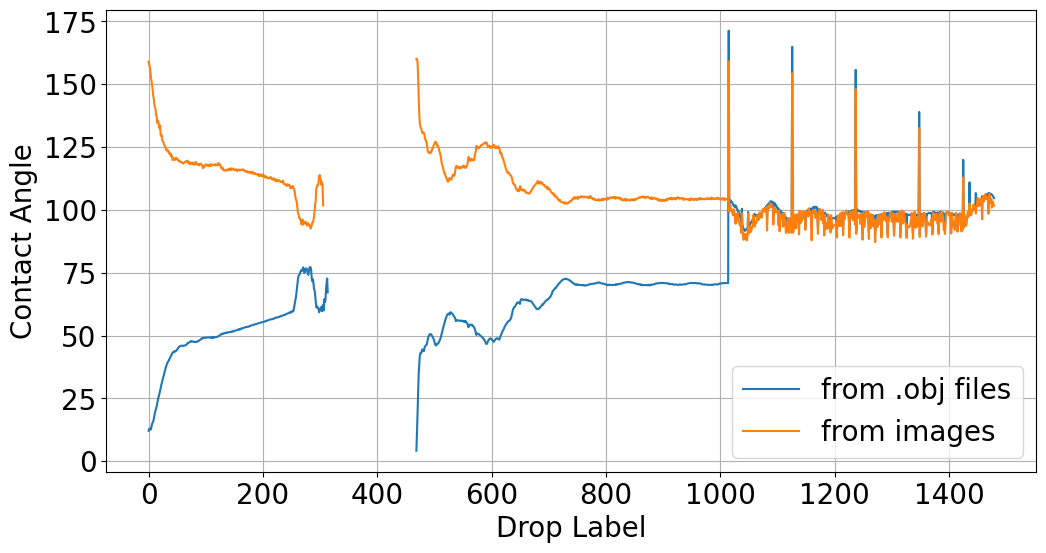

In [16]:
#Lets see the updated plot:
plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams['font.size'] = 20
plt.grid(True)
plt.plot(np.linspace(0,len(y_data),len(y_data)), y_data["Contact Angle"], label = "from .obj files")
plt.plot(np.linspace(0,len(sorted_angles),len(sorted_angles)), sorted_angles, label = "from images")
plt.xlabel('Drop Label')
plt.ylabel('Contact Angle')
plt.legend(loc="lower right")
plt.show()